In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(file_path)
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)
    
import time
import jax
from jax import lax
from jax import flatten_util
from jax import vmap
import jax.numpy as jnp
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, vjp, value_and_grad,jit
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio
from scipy.stats import wasserstein_distance
from scipy.linalg import cholesky,LinAlgError
from scipy import sparse
from scipy.io import loadmat

import jax
import jax.numpy as jnp
import jaxopt
import matplotlib as mpl
#Our library
from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *
from Crunch.Optimizers.minimize import  minimize
#Random Library
import random




Project root: /oscar/data/gk/jdtoscan/PIML/Crunch_PIML


In [2]:
#from jax import config
#config.update("jax_default_matmul_precision", "float32")
jax.config.update("jax_enable_x64", True)

# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"



In [3]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [4]:
import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='Burgers', help='Name of equation')
parser.add_argument('--Name', type=str, default='SS-RBA', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=200000, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=9999, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=5000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=3, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=30, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=1, help='Feature size')
parser.add_argument('--degree', type=int, default=9, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=2, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_bfgs', type=float, default=0.1, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=1.0, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--batch_size', type=int, default=20000, help='batch_size')
parser.add_argument('--k_samp', type=float, default=1.0, help='Enhance outliers smoothing factor')
parser.add_argument('--c_samp', type=float, default=0.0, help='homogenize')
parser.add_argument('--phi', type=float, default=0.0, help='Enhance outliers smoothing factor')
parser.add_argument('--c_log', type=float, default=1.0, help='homogenize')
parser.add_argument('--N_change', type=int, default=100, help='homogenize')

# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))

# vRBA
c_log=args.c_log
phi=args.phi
# Second order_ Sampling
k_samp_bfgs = args.k_samp
c_samp_bfgs = args.c_samp
Nchange = args.N_change
batch_size=args.batch_size

args.Name=args.Name+f'vRBA-phi:{phi:.2f}-c_log:{c_log:.2f}-bs:{batch_size}_k:{k_samp_bfgs:.2f}_N:{Nchange:.2f}_Seed:{SEED}'+args.Note
print(args.Name)

# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


Equation: Burgers
Name: SS-RBA
NC: 200000
NI: 512
NB: 512
NC_TEST: 100
SEED: 9999
EPOCHS: 5000
N_LAYERS: 3
HIDDEN: 30
FEATURES: 1
degree: 9
degree_T: 2
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_bfgs: 0.1
gamma_grads: 0.99
alpha: 1.0
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
batch_size: 20000
k_samp: 1.0
c_samp: 0.0
phi: 0.0
c_log: 1.0
N_change: 100
SS-RBAvRBA-phi:0.00-c_log:1.00-bs:20000_k:1.00_N:100.00_Seed:9999


In [5]:
#import tensorflow as tf
from tensorboardX import  SummaryWriter
args.Name =project_root+'/Results/'+args.Equation+'/'+args.Name+'/'
log_dir =args.Name  # specify the directory where logs will be saved
writer = SummaryWriter(log_dir)
print(log_dir)

/oscar/data/gk/jdtoscan/PIML/Crunch_PIML/Results/Burgers/SS-RBAvRBA-phi:0.00-c_log:1.00-bs:20000_k:1.00_N:100.00_Seed:9999/


## 1. PINN

In [6]:
kmax=1
Lx=2.0

In [7]:
class MLP(nn.Module):
    degree: int
    features: Sequence[int]
    M:int =10
    def setup(self):
         self.T_funcs = [globals()[f"T{i}"] for i in range(self.degree+1)] 
    @nn.compact
    def __call__(self, t, x):
        init = nn.initializers.glorot_normal()
        ks=jnp.arange(1,kmax+1)
        Xper = 2*jnp.pi*jnp.matmul(x,ks[None,:])/Lx
        xcos = jnp.cos(Xper)
        xsin = jnp.sin(Xper)
        Xper = jnp.concatenate([xcos,xsin],axis=1)
        Z = jnp.concatenate([t, Xper], axis=-1)
        for fs in self.features[:-1]:
            Z = nn.Dense(fs, kernel_init=init)(Z)
            Z = nn.activation.tanh(Z)
        Z = nn.Dense(self.features[-1], kernel_init=init)(Z)
        return Z

In [8]:
# forward function
class PINN(nn.Module):
    degree: int
    degree_T:int
    features: Sequence[int]
    M:int =10
    def setup(self):
         self.MLP = MLP(degree=self.degree,features=self.features,M=self.M)
    @nn.compact
    def __call__(self, t, x):
        u=self.MLP(t,x)
        u=-jnp.sin(2*jnp.pi*x/Lx)+t*u
        return u
# optimizer step function
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [9]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [10]:
nu=1/(100*jnp.pi)
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,idx_train,it, *train_data):
    # Unpack data
    t, x, ti, xi, ui = train_data
    lambdas_it = lambdas[idx_train]

    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        ux,uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,),return_primals=True)
        # Compute residuals using u, ut, and uxx
        return ut +u*ux-nu*uxx

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        q_it=r_i#
        lambda_it=q_it/q_it.max()
        new_lambdas = gamma * lambdas + eta*lambda_it
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean((residuals)**2)
        return pde_loss, new_lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas_it)
    #Store
    all_loss={
        'loss_PDE':pde_loss,
        'loss_BCs':0.0,
        'Loss':pde_loss 
    }
    all_grads={
        'grad_bar_PDE':0.0,
        'grad_bar_BCs':0.0,
        'grad_PDE':0.0,
        'grad_BCs':0.0,
    }
    return all_loss, gradient_pde, lambdas,lamB,all_grads

In [11]:
@partial(jax.jit, static_argnums=(0,))
def get_residuals(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui = train_data
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        ux,uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,),return_primals=True)
        # Compute residuals using u, ut, and uxx
        return ut +u*ux-nu*uxx

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        return residuals**2

    # Compute residuals
    residuals=loss_pde(params, lambdas)
    return  residuals

In [12]:
@partial(jax.jit, static_argnums=(0,))
def get_gradient(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui= train_data
    
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        ux,uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,),return_primals=True)
        # Compute residuals using u, ut, and uxx
        return ut +u*ux-nu*uxx

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean(( residuals) ** 2)
        return pde_loss, lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)

    # Combine loss and gradients
    gradient_flat_inner, _ = flatten_util.ravel_pytree(gradient_pde)#['params']['get_Psi'])
    #gradient_flat_outer, _ = flatten_util.ravel_pytree(total_gradient['params']['RBF_KAN_layer_0'])
    return  gradient_flat_inner/(jnp.linalg.norm(gradient_flat_inner)+1e-20),0.0#,gradient_flat_outer/(jnp.linalg.norm(gradient_flat_outer)+1e-10)

In [13]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

In [14]:
def KL_divergence(p, q):
    term1 = jax.scipy.special.xlogy(p, p)
    term2 = jax.scipy.special.xlogy(p, q)
    return jnp.sum(term1 - term2)

def get_pdf(u_hist, bins=100):
    hist_densities, bin_edges = jnp.histogram(u_hist, bins=bins, density=True)
    bin_widths = jnp.diff(bin_edges)
    prob_density_corrected = hist_densities* bin_widths
    return prob_density_corrected, bin_edges

def get_metrics(e,apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,tc,xc,N_batches=50):    
    Var={}
    distance={}
    histograms={}
    # p variance
    all_res=[]
    for batch_n in (range(N_batches)):
        #Select data
        idx_train,train_data_batch=sample_points_pdf(e+batch_n, batch_size, lambdas,tc,xc, k=0, c=1.0)  # 0 means uniform sampling
        # Get Gradient
        residuals=get_residuals(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB, *train_data_batch)
        all_res.append(residuals.flatten())
    all_res=jnp.vstack(all_res)
    all_res=all_res.flatten()
    Var['p']=jnp.std(all_res)**2
    p_res=(lambdas.flatten())*0+1
    p_res=p_res/p_res.sum()
    # q variance
    all_res=[]
    for batch_n in (range(N_batches)):
        #Select data
        idx_train,train_data_batch=sample_points_pdf(e+batch_n, batch_size, lambdas,tc,xc, k=1.0, c=0.0)  # 1 means resampling
        # Get Gradient
        residuals=get_residuals(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB, *train_data)
        all_res.append(residuals.flatten())

    all_res=jnp.vstack(all_res)
    all_res=all_res.flatten()
    prob_density, bins=get_pdf(all_res, bins=20)
    Var['q']=jnp.std(all_res)**2
    q_res=lambdas.flatten()+1e-20
    q_res=q_res/q_res.sum()
    distance['wd']=wasserstein_distance(p_res,q_res)
    distance['KL']=KL_divergence(p_res,q_res)
    histograms['q_pdf']=q_res
    return Var,distance


In [15]:
def get_SRN(apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,X_batches):    
    all_gradients={
        'inner':[],
        #'outer':[],
    }
    for X_batch in X_batches:
        #Select data
        train_data_batch=X_batch[:,0:1],X_batch[:,1:2],ti,xi,ui
        # Get Gradient
        gradient_flat_inner,gradient_flat_outer=get_gradient(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB, *train_data_batch)
        all_gradients['inner'].append(gradient_flat_inner)
        #all_gradients['outer'].append(gradient_flat_inner)
    grad_SNR={}
    for key in all_gradients.keys():
        array_grad=jnp.array(all_gradients[key])
        mean_grad=jnp.mean(array_grad,axis=0)
        std_grad=jnp.std(array_grad,axis=0)
        norm_mean_grad=jnp.linalg.norm(mean_grad)
        norm_std_grad=jnp.linalg.norm(std_grad)
        grad_SNR[key]=np.array(norm_mean_grad/norm_std_grad)
    return grad_SNR


In [16]:
@partial(jax.jit, static_argnames=("batch_size", "k", "c"))
def sample_points_pdf(e, batch_size, lambdas,tc,xc, k=1, c=0.5):
    key = jax.random.PRNGKey(e)
    
    # Adjust lambdas with exponent k and normalize
    lambdas_k = lambdas**k
    lambdas_k = lambdas_k / lambdas_k.mean() + c

    # Ensure the probabilities array is 1D and matches the shape of lambdas
    lambdas_k = lambdas_k.flatten()
    p = lambdas_k / lambdas_k.sum()

    # Sample indices according to the probability distribution
    idx_train = jax.random.choice(
        key, len(lambdas), shape=(batch_size,), p=p
    )
    train_data=tc[idx_train],xc[idx_train],ti,xi,ui
    return idx_train,train_data


# Load Data

In [17]:
# Load data from the .mat file
data = scipy.io.loadmat('../Data/burgers.mat')
print(data.keys())
Exact = data['usol'].T
Exact0 = np.real(Exact).astype(jnp.float64)  # <-- CAST HERE
t0 = data['t'].flatten()[:,None].astype(jnp.float64)      # <-- CAST HERE
x0 = data['x'].flatten()[:,None].astype(jnp.float64)       # <-- CAST HERE
T, X = np.meshgrid(t0, x0)

# Ground Truth (already float64 due to T, X)
t = T.flatten()[:,None]
x = X.flatten()[:,None]
u_gt = Exact0.flatten()[:,None]

# Collocation points
lb_D = jnp.array([t0.min(), x0.min()])
ub_D = jnp.array([t0.max(), x0.max()])

# Generate collocation points and ensure they are float64
X_c = lb_D + (ub_D - lb_D) * lhs(2, NC)
X_c = X_c.astype(jnp.float64)  # <-- CAST HERE
tc = X_c[:, 0:1]
xc = X_c[:, 1:2]

# Initial conditions (already float64 due to T, X, Exact0)
ti = T[:, 0:1]
xi = X[:, 0:1]
ui = Exact0[:, 0:1]

# Boundary Conditions (not used in the 2nd order part, but good practice)
keys = jax.random.split(key, 13)
tb = jax.random.uniform(keys[3], (NB, 1), minval=lb_D[0], maxval=ub_D[0]).astype(jnp.float64)

# This data tuple is now consistently float64
train_data = tc, xc, ti, xi, ui
lambdas = tc * 0 + 0.1

dict_keys(['__header__', '__version__', '__globals__', 't', 'usol', 'x'])


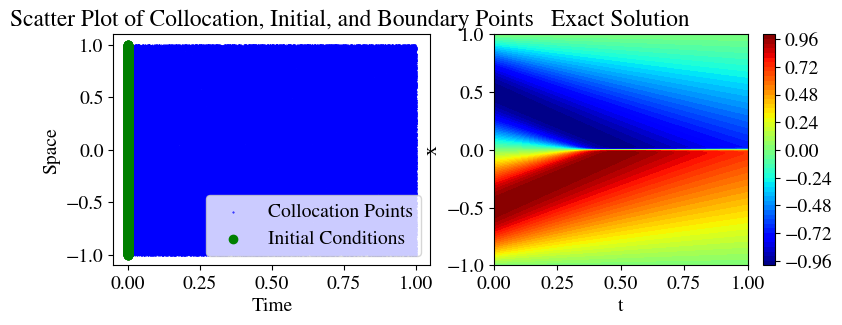

In [18]:
# Plotting code
fig = plt.figure(figsize=(9, 3))

# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()

# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.show()

In [19]:
# Batches SNR
n_batches=100
X_c2= lb_D + (ub_D-lb_D)*lhs(2, 2*NC)
X_batches=np.array(np.split(X_c2,n_batches))
X_batches.shape


(100, 4000, 2)

## Initialize Model

In [20]:

# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,degree_T,feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1), dtype=jnp.float64), jnp.ones((NC, 1), dtype=jnp.float64))
params = jax.tree_util.tree_map(lambda x: x.astype(jnp.float64), params)
optimizers = {}
for key in params['params'].keys():
    if key=='g_fx':
        print('KART layer')
        optimizers[key]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))
    else:
        optimizers[key]=optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False))

# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(30, 30, 30, 1)
2011


In [21]:
def get_g_x(params, t, x):
    # Compute u
    u = apply_fn(params, t, x)
    # Compute derivatives
    v_t = jnp.ones_like(t)
    v_x = jnp.ones_like(x)
    u_t = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
    u_x = jvp(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))[1]
    return jnp.hstack([u_t,u_x])


In [22]:
@jit
def get_GC(params,t,x):
    g_x=get_g_x(params, t, x)[:,:,None]
    norm_f_tx = jnp.linalg.norm(g_x, ord='fro', axis=(1, 2))**2
    model_gc=jnp.mean(norm_f_tx)
    return model_gc
print(get_GC(params,t,x))


8.64812190318479


In [23]:
all_errors = []
all_L_infty = []
all_L_2 = []

all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []
all_SNR_psi = []
all_SNR_g = []
all_lamE = []
all_lambdas=[]
all_idx=[]
all_Var_p = []
all_Var_q = []
all_d= []
all_KL= []
all_gc = []



start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/(EPOCHS/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # sample batch 
    idx_train,train_data=sample_points_pdf(e, batch_size, lambdas,tc,xc, k=0, c=1.0) # K=0 implies uniform sampling
    # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,idx_train,e, *train_data)

    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        #Compute SNR
        grad_SNR=get_SRN(apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,X_batches)
        #Compute variance
        Var,distance=get_metrics(e,apply_fn,params, lambdas,gamma_it,eta,lamE,lamB,tc,xc)
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        #gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        all_idx.append(idx_train)
        #Compute errors
        u_pred_it=apply_fn(params, t, x)
        error = relative_l2(u_pred_it, u_gt)
        error_vec = u_pred_it - u_gt
        L_infty = scipy.linalg.norm(error_vec.flatten(), ord=np.inf)
        L_2 = scipy.linalg.norm(error_vec.flatten(), ord=2)
        # Geometric Complexity
        model_gc=get_GC(params,t,x)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|")
        # Log metrics to TensorBoard
        writer.add_scalar('Error', error, global_step=e)
        writer.add_scalar('lam_max', lambdas.max(), global_step=e) 
        writer.add_scalar('max_RBA', max_RBA, global_step=e)
        writer.add_scalar('lamB', lamB, global_step=e)
        writer.add_scalar('gamma_it', gamma_it, global_step=e)
        writer.add_scalar('Var_p', Var['p'], global_step=e)
        writer.add_scalar('Var_q', Var['q'], global_step=e)
        writer.add_scalar('Wasserstein', distance['wd'], global_step=e)
        writer.add_scalar('KL', distance['KL'], global_step=e)
        writer.add_scalar('SNR', grad_SNR['inner'], global_step=e)
        # for key in grad_SNR.keys():
        #     writer.add_scalar('SNR_'+key, grad_SNR[key], global_step=e)
        for key in all_loss_it.keys():
            writer.add_scalar(key, all_loss_it[key], global_step=e)
        for key in all_grads.keys():
            writer.add_scalar(key, all_grads[key], global_step=e)
        # Append metrics to lists
        all_Var_q.append(Var['q'])
        all_Var_p.append(Var['p'])
        all_d.append(distance['wd'])
        all_KL.append(distance['KL'])
        all_SNR_psi.append(grad_SNR['inner'])
        #all_SNR_g.append(grad_SNR['outer'])
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)
        all_lamE.append(lamE)
        all_gc.append(model_gc)
        # Error norms
        all_L_infty.append(L_infty)
        all_L_2.append(L_2)
end = time.time()
writer.close()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-08-01 10:24:33.809291: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce-window.2 = f64[12500,16]{0,1} reduce-window(%broadcast.117, %constant.16), window={size=1x16 pad=0_0x15_0}, to_apply=%region_2.44

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-08-01 10:24:36.959439: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 4.150229255s
Constant folding an instruction is taking > 1s:

  %reduce-window.2 = f64[12500,16]{0,1} reduce-window(%broadcast.117, %constant.16), window={size=1x16 pad=0_0x15_0}, to_apply=%region_2.44

This isn't necessaril

Runtime: 98.54 ms/iter.


# Save Results

In [24]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_Var_q': all_Var_q,
    'all_Var_p': all_Var_p,
    'all_d': all_d,
    'all_KL': all_KL,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
    'all_SNR_psi': all_SNR_psi,
    'all_SNR_g': all_SNR_g,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


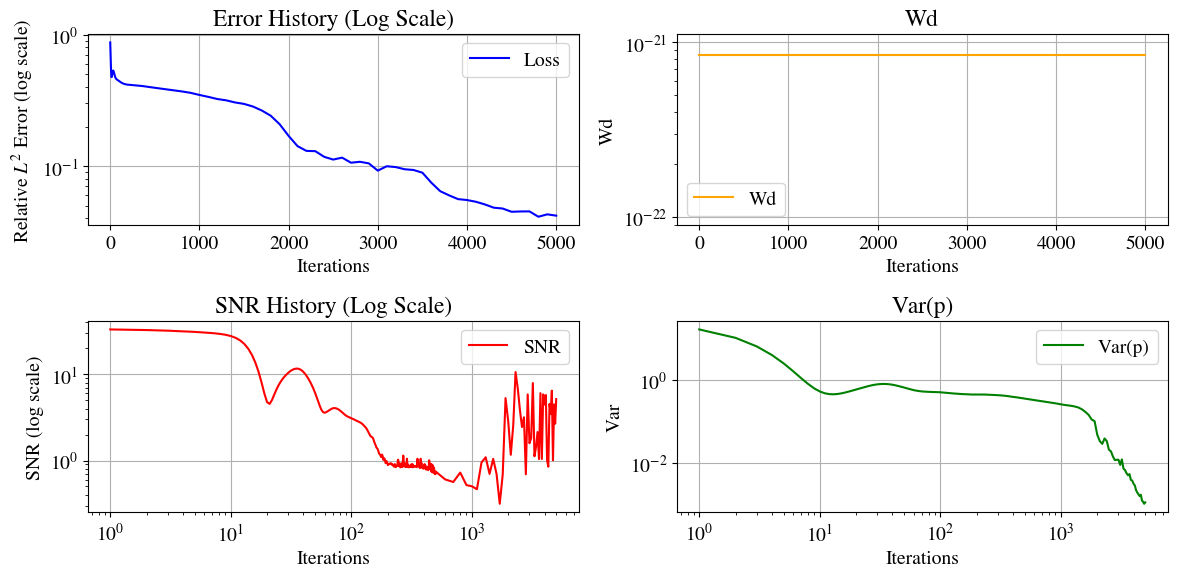

In [25]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_errors, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative $L^2$ Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_SNR_psi, label='SNR', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('SNR (log scale)')
plt.title('SNR History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_d, label='Wd', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Wd')
plt.title('Wd')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(all_its, all_Var_p, label='Var(p)', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Var')
plt.title('Var(p)')
plt.grid(True)
plt.legend()


# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [26]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.04198367


Solution:


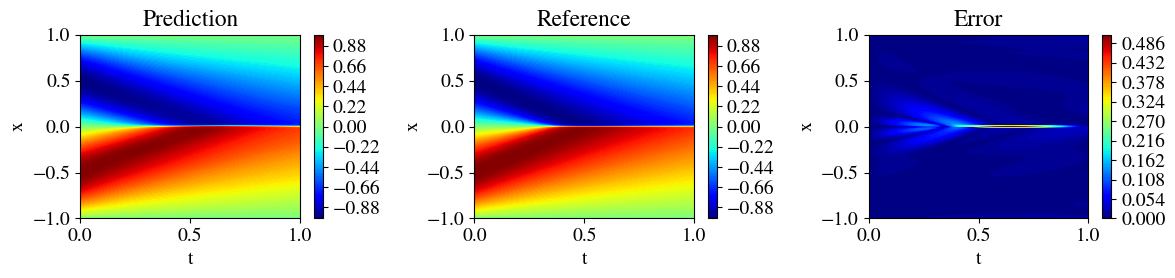

In [27]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(12, 3))
levels=100
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(131)
contour = ax1.contourf(T, X, u, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(133)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
plt.tight_layout()

plt.savefig(args.Name+'Errorss_RBA-R.png',dpi=300)
plt.show()

### Second Order

In [28]:
cont=0
method='BFGS'
Nprint_bfgs=100
method_bfgs='SSBroyden2'
Nbfgs=100000
# Others
X0 = np.hstack((ti,xi,ui))
# Resampling
def generate_points(NC=100000):
    X_c= lb_D + (ub_D-lb_D)*lhs(2, NC)
    tc=X_c[:,0:1]
    xc=X_c[:,1:2]
    lambdas=X_c[:,0:1]*0+1.0
    return tc,xc,lambdas
gamma=0.0
eta=1.0
initial_weights, unflatten_func = flatten_util.ravel_pytree(params)
params_test=unflatten_func(initial_weights)
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 
error = relative_l2(apply_fn(params_test, t, x), u_gt)
print(f'Reconstructed parameters: RL2 error: {error:.8f}') 
X=np.hstack([tc.astype(jnp.float64),xc.astype(jnp.float64)])

RL2 error: 0.04198367
Reconstructed parameters: RL2 error: 0.04198367


In [29]:
@partial(jax.jit, static_argnums=(0,))
def apply_model_2nd_Order(apply_fn, params, *train_data):
    # Unpack data
    t, x, ti, xi, ui = train_data
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        ux,uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,),return_primals=True)
        # Compute residuals using u, ut, and uxx
        return ut +u*ux-nu*uxx

    def loss_pde(params):
        # Compute residuals
        residuals = r_E(params, t, x)
        pde_loss = jnp.mean((residuals)**2)
        return pde_loss

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss
    
    def loss(params):
        return loss_pde(params)

    loss_value=loss(params)
    return loss_value

In [30]:
@partial(jax.jit, static_argnums=(0,))
def update_lambdas(apply_fn,params,lambdas,gamma,eta,tc,xc,it):
    t,x=tc,xc
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        ux,uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,),return_primals=True)
        # Compute residuals using u, ut, and uxx
        return ut +u*ux-nu*uxx

    def get_lambdas(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        q_it=r_i#
        lambda_it=q_it/q_it.max()
        new_lambdas = gamma * lambdas + eta*lambda_it
        return new_lambdas
    new_lambdas=get_lambdas(params, lambdas)
    return new_lambdas

In [31]:
@partial(jax.jit, static_argnums=(1, 2))
def loss_and_gradient(weights, N_arg, unflatten_func_arg, *train_data_tuple_arg):
    flat_jax_array = weights 
    params_current = unflatten_func_arg(flat_jax_array)
    loss_val_jax = apply_model_2nd_Order(N_arg, params_current, *train_data_tuple_arg)
    return loss_val_jax

In [32]:
def sample_points_pdf_2nd(key, batch_size, lambdas,tc,xc, k=1, c=0.5):    
    # Adjust lambdas with exponent k and normalize
    lambdas_k = lambdas**k
    lambdas_k = lambdas_k / lambdas_k.mean() + c

    # Ensure the probabilities array is 1D and matches the shape of lambdas
    lambdas_k = lambdas_k.flatten()
    p = lambdas_k / lambdas_k.sum()

    # Sample indices according to the probability distribution
    idx_train = jax.random.choice(
        key, len(lambdas), shape=(batch_size,), p=p
    )
    train_data=tc[idx_train],xc[idx_train],ti,xi,ui
    return idx_train,train_data


In [33]:

@partial(jax.jit, static_argnames=("apply_fn", "unflatten_func", "batch_size", "gamma", "eta", "k", "c", "static_options"))
def bfgs_step(
    # DYNAMIC STATE (changes every iteration)
    initial_weights, H0, key,
    # DYNAMIC DATA (changes every iteration)
    tc, xc, lambdas,
    # STATIC CONFIGURATION (fixed for the run)
    apply_fn, unflatten_func, batch_size, gamma, eta, k, c, static_options,it
):
    """
    Performs one full, JIT-compiled iteration of the BFGS training loop.
    """
    # 1. Handle the PRNG key state purely
    key, subkey = jax.random.split(key)

    # 2. Update Lambdas based on the current model
    params_it = unflatten_func(initial_weights)
    updated_lambdas = update_lambdas(apply_fn, params_it, lambdas, gamma, eta, tc, xc,it)

    # 3. Sample a batch using the updated lambdas and the subkey
    # The original 'train_data' is (tc, xc, ti, xi, ui), so we recreate it with the new batch.
    # We assume ti, xi, ui are constants for this problem.
    _ , current_train_data_tuple = sample_points_pdf_2nd(subkey, batch_size, updated_lambdas, tc, xc, k, c)

    # 4. Prepare the full options dictionary for minimize
    current_options = dict(static_options)
    current_options['initial_H'] = H0

    # 5. Run the BFGS optimization for Nchange steps
    result = minimize(
        fun=loss_and_gradient,
        x0=initial_weights,
        args=(apply_fn, unflatten_func, *current_train_data_tuple),
        method='BFGS',
        options=current_options
    )

    # 6. Recycle the Hessian purely
    new_H0 = result.hess_inv
    new_H0 = (new_H0 + jnp.transpose(new_H0)) / 2
    try:
        # Cholesky can fail, so we wrap it. JAX's lax.cond is safer inside JIT.
        L = jnp.linalg.cholesky(new_H0)
        is_failed = jnp.any(jnp.isnan(L))
        final_H0 = jax.lax.cond(
            is_failed,
            lambda op: jnp.eye(op.shape[0], dtype=op.dtype),
            lambda op: op,
            operand=new_H0
        )
    except LinAlgError:
        final_H0 = jnp.eye(new_H0.shape[0], dtype=new_H0.dtype)


    # 7. Return all pieces of the new state
    return result.x, final_H0, key, result.fun, result.nit, updated_lambdas

In [34]:
initial_weights, unflatten_func = flatten_util.ravel_pytree(params)
H0 = jnp.eye(len(initial_weights), dtype=jnp.float64)
key = jax.random.PRNGKey(SEED + 1) # Use a new seed to avoid reusing keys

# 2. Prepare Static Configuration
NC = 200000
gamma = args.gamma_bfgs
eta = 1-gamma
num_outer_iterations = Nbfgs // Nchange

# Create the static options dictionary WITHOUT the dynamic H0
static_options = {
    'maxiter': Nchange,
    'gtol': 1e-9,
    'update_method': "ssbroyden2",
    'initial_scale': True,
    'ls_normal_c1': 1e-4, 'ls_normal_c2': 0.9, 'ls_normal_maxiter': 15,
    'ls_fb_c1_try1': 1e-4, 'ls_fb_c2_try1': 0.8, 'ls_fb_maxiter_try1': 10,
    'ls_fb_c1_try2': 1e-4, 'ls_fb_c2_try2': 0.5, 'ls_fb_maxiter_try2': 25
}
# Convert to a hashable, immutable tuple for JIT
static_options_tuple = tuple(static_options.items())
key = jax.random.PRNGKey(42)
# --- THE JIT-POWERED LOOP ---
pbar = tqdm(range(num_outer_iterations), desc="BFGS Training")
# A. Prepare data for this iteration (This part runs in Python using NumPy)
tc_np, xc_np, lambdas_np = generate_points(NC)

# B. Convert data to JAX arrays to pass into the JITted function
tc, xc, updated_lambdas = jnp.array(tc_np), jnp.array(xc_np), jnp.array(lambdas_np)
effective_steps=0
Adam_Steps=all_its[-1]
for it in pbar:
    # C. Execute one full, compiled training step
    initial_weights, H0, key, loss_val, nit, updated_lambdas = bfgs_step(
        # Dynamic State
        initial_weights, H0, key,
        # Dynamic Data
        tc, xc, updated_lambdas,
        # Static Configuration
        apply_fn, unflatten_func, batch_size, gamma, eta, k_samp_bfgs, c_samp_bfgs,
        static_options_tuple,it
    )
    # Current step
    effective_steps=effective_steps+nit
    # The state variables (initial_weights, H0, key) are now updated for the next iteration.
    current_params_for_eval = unflatten_func(initial_weights)
    Var,distance=get_metrics(it,apply_fn,current_params_for_eval, updated_lambdas,gamma_it,eta,lamE,lamB,tc,xc)
    # D. Post-step analytics and logging (runs in Python)
    #Compute errors
    u_pred_it=apply_fn(current_params_for_eval, t, x)
    error = relative_l2(u_pred_it, u_gt)
    error_vec = u_pred_it - u_gt
    L_infty = scipy.linalg.norm(error_vec.flatten(), ord=np.inf)
    L_2 = scipy.linalg.norm(error_vec.flatten(), ord=2)
    # Geometric Complexity
    model_gc=get_GC(current_params_for_eval,t,x)
    #Compute SNR
    grad_SNR=get_SRN(apply_fn,current_params_for_eval, lambdas,gamma_it,eta,lamE,lamB,X_batches)
    # Save metrics
    all_errors.append(error)
    all_loss.append(loss_val)
    all_Var_q.append(Var['q'])
    all_Var_p.append(Var['p'])
    all_d.append(distance['wd'])
    all_KL.append(distance['KL'])
    all_its.append(effective_steps+Adam_Steps)
    all_SNR_psi.append(grad_SNR['inner'])
    all_gc.append(model_gc)
    # Log metrics to TensorBoard
    writer.add_scalar('Error', error, global_step=e)
    writer.add_scalar('Var_p', Var['p'], global_step=e)
    writer.add_scalar('Var_q', Var['q'], global_step=e)
    writer.add_scalar('Wasserstein', distance['wd'], global_step=e)
    writer.add_scalar('KL', distance['KL'], global_step=e)
    writer.add_scalar('SNR', grad_SNR['inner'], global_step=e)
    # Error norms
    all_L_infty.append(L_infty)
    all_L_2.append(L_2)
    pbar.set_postfix({
        'It': effective_steps,
        'Loss': f'{loss_val:.3e}',
        'RL2': f'{float(error):.3e}',
        'lam_min': f'{jnp.min(updated_lambdas):.3e}',
        'lam_max': f'{jnp.max(updated_lambdas):.3e}',
    }) 

BFGS Training: 100%|██████████| 1000/1000 [25:06<00:00,  1.51s/it, It=61445, Loss=7.876e-14, RL2=1.950e-08, lam_min=5.813e-05, lam_max=9.176e-01]


In [35]:
T, X = np.meshgrid(t0, x0)
# Ground Truth (already float64 due to T, X)
t = T.flatten()[:,None]
x = X.flatten()[:,None]
u_gt = Exact0.flatten()[:,None]
it=-1
print('Solution:')
u = apply_fn(current_params_for_eval, t, x)
u = u.reshape(T.shape)

Solution:


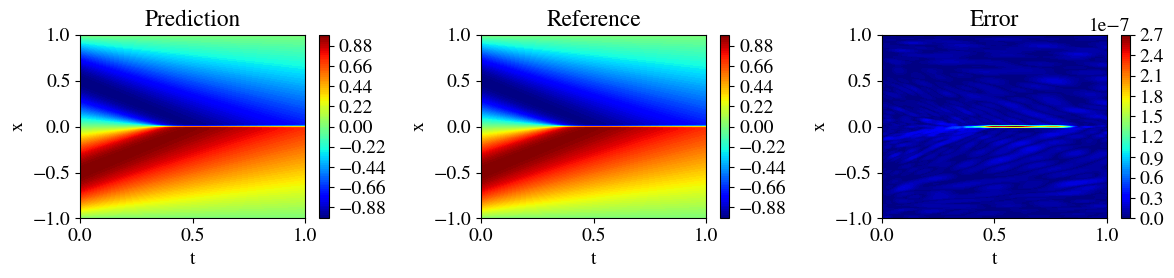

In [36]:

lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(12, 3))
levels=100
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(131)
contour = ax1.contourf(T, X, u, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(133)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
plt.tight_layout()

plt.savefig(args.Name+'Errorss_RBA-R.png',dpi=300)
plt.show()

Solution:


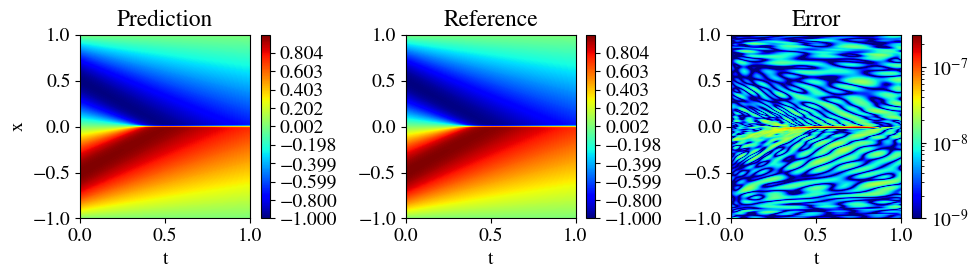

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

it=-1
print('Solution:')

# --- 1. Find the global vmin and vmax across BOTH datasets ---
global_vmin = np.min([u, Exact0])
global_vmax = np.max([u, Exact0])

# --- 2. Create a shared array of contour levels ---
# This is the key change that guarantees the colorbars are identical.
num_levels = 500
shared_levels = np.linspace(global_vmin, global_vmax, num_levels)


# Plotting code
fig = plt.figure(figsize=(10, 3))

# --- Plot for Prediction (using the shared levels array) ---
ax1 = fig.add_subplot(131)
contour1 = ax1.contourf(T, X, u, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# --- Plot for Reference Solution (using the shared levels array) ---
ax2 = fig.add_subplot(132)
contour2 = ax2.contourf(T, X, Exact0, cmap='jet', 
                        levels=shared_levels) # <-- Use the shared levels array
fig.colorbar(contour2, ax=ax2)
ax2.set_xlabel('t')
#ax2.set_ylabel('x')
ax2.set_title('Reference')

# --- Plot for Error (this part is separate and correct) ---
ax3 = fig.add_subplot(133)
error_data = np.abs(Exact0-u)
log_norm = colors.LogNorm(vmin=1e-9, vmax=error_data.max())

mesh3 = ax3.pcolormesh(T, X, error_data, 
                       cmap='jet', 
                       norm=log_norm,
                       shading='gouraud')

fig.colorbar(mesh3, ax=ax3)
ax3.set_xlabel('t')
#ax3.set_ylabel('x')
ax3.set_title('Error')

plt.tight_layout()
plt.savefig(args.Name+'Errors_RBA_AC.png',dpi=300)
plt.show()

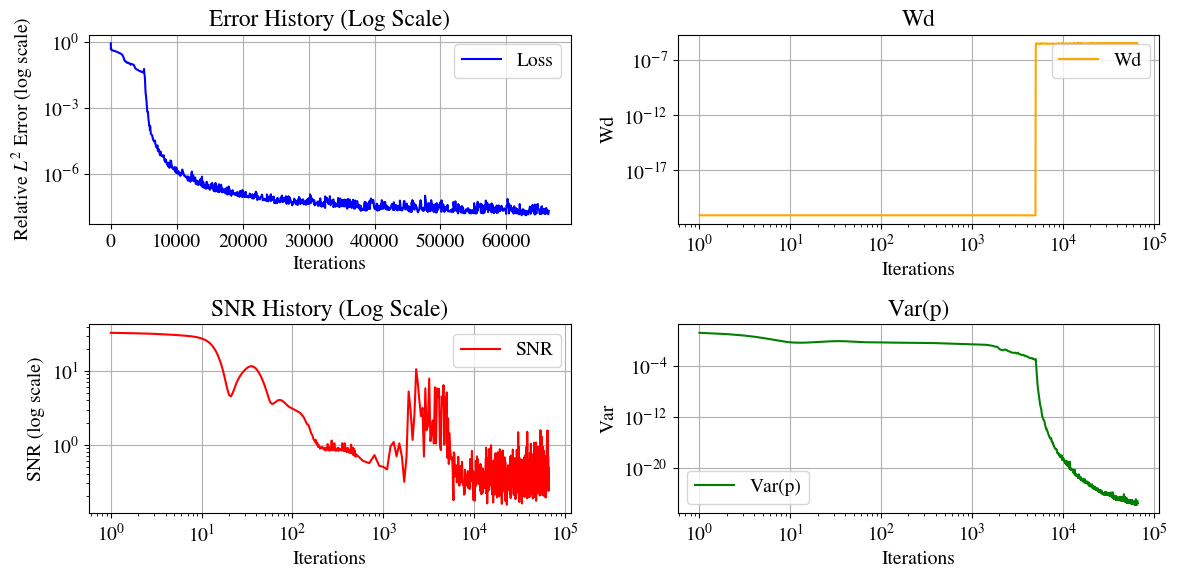

In [38]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_errors, label='Loss', color='blue')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative $L^2$ Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_SNR_psi, label='SNR', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('SNR (log scale)')
plt.title('SNR History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_d, label='Wd', color='orange')
plt.xscale('log')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Wd')
plt.title('Wd')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(all_its, all_Var_p, label='Var(p)', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Var')
plt.title('Var(p)')
plt.grid(True)
plt.legend()


# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [39]:
print('Minimum achieved error:',np.nanmin(all_errors))

Minimum achieved error: 1.246457196617865e-08


In [41]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_Var_q': all_Var_q,
    'all_Var_p': all_Var_p,
    'all_d': all_d,
    'all_KL': all_KL,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
    'all_SNR_psi': all_SNR_psi,
    'all_SNR_g': all_SNR_g,
    'all_L_infty':all_L_infty,
    'all_L_2':all_L_2,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files_SSBroyden.mat', results_dict)

In [42]:
len(error_vec)

2003001